# Dynamic Seasonality in NEWT

This Notebook deals with the implementation of "dynamic seasonality" in TempEst-NEWT.

Previous experiments have shown that "anomaly" (difference between temperature and day-of-year mean temperature) is dominated by seasonal-scale shifts (e.g., low snowpack = warm spring and summer), not short-term weather response.  This probably explains the poor performance of earlier (TempEst 2) anomaly models, which can only explain about half of the variance in anomaly (which itself is only 10% of overall variance, so general performance can be very good).

Therefore, it's necessary to dynamically predict seasonality departure in a year.  I will analyze this by fitting seasonality for *each* year and comparing it to the baseline to see what prominent departures tend to be and whether they are predictable.  I anticipate that melt-date (sustained temperatures above zero) and snowpack volume will probably be decisive.  Precipitation departures may also be key, to anticipate drought conditions.

I do not know if an interpretable statistical model will be effective, but this would be a good use case for a neural net mapping monthly snowpack + precipitation + AT departures and peak snowpack date to 3S departures.

In [9]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
from NEWT import Watershed as WS
pd.options.mode.chained_assignment = None

def trycatch(op):
    try:
        return op()
    except ValueError:
        return None

In [ ]:
data = pd.read_csv("AllData.csv", dtype={"id": "str"}).rename(columns={"temperature.mean": "temperature"})
data["date"] = pd.to_datetime(data["date"])

def get_candidate(cid):
    return data[data["id"] == cid]

In [19]:
# This is Eagle River Below Milk Creek Near Wolcott, CO
# Appears to be unregulated, freezes in winter, max temperature ~20 C, discharge ~50-2000 cfs,
# elevation ~2100 m
candidate_eagle = "394220106431500"

cid = candidate_eagle
csd = get_candidate(cid).assign(year = lambda x: x["date"].dt.year,
                               day = lambda x: x["date"].dt.day_of_year)

csd.groupby("year")["temperature"].count()

year
2007     92
2008    358
2009    365
2010    363
2011    365
2012    365
2013    365
2014    361
2015    361
2016    364
2017    355
2018    365
2019    365
2020    365
2021    365
2022    365
Name: temperature, dtype: int64

In [5]:
print(csd["date"].min())
print(csd["date"].max())

2007-10-01 00:00:00
2022-12-31 00:00:00


In the Eagle River case study:

- Intercept varies between about 6 and 8 C, but that could conceivably be reflected in air temperature anomaly
- Amplitude varies between 6 and 9 C
- SpringSummer varies from 2 to >4 C - highly variable
- FallWinter varies from 1 to 2.6 C - also highly variable, but less relevant
- FallDay and SummerDay vary by 40 days
- WinterDay varies by 30 days
- SpringDay varies by 20 days

For this particular watershed, at least, peak SWE is uninformative - though this could be due to iffy data.

In [44]:
csd_ssn = csd[csd["date"] >= "2008-01-01"].groupby("year")[["day", "temperature"]].\
                                                    apply(lambda x: rts.ThreeSine.from_data(x).to_df()).drop(columns=["R2", "RMSE"])
csd_ssn

,,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter
year,,,,,,,,,
2008,0,6.251127,6.673703,326.0,92.0,166.0,240.0,3.206646,1.060696
2009,0,6.508226,6.735778,334.0,69.0,160.0,239.0,2.784821,2.271186
2010,0,7.076022,7.527834,327.0,76.0,159.0,211.0,3.572029,1.697710
2011,0,6.134418,6.426896,322.0,84.0,169.0,239.0,3.658692,1.714179
2012,0,8.017570,8.693729,314.0,82.0,149.0,207.0,2.056708,1.995754
2013,0,6.909968,7.893196,302.0,83.0,153.0,240.0,3.317203,2.264069
2014,0,6.637920,6.904851,316.0,70.0,160.0,219.0,3.118325,1.745333
2015,0,7.232061,6.966485,325.0,83.0,158.0,229.0,2.910690,2.127278
2016,0,7.075387,7.055681,338.0,68.0,157.0,216.0,2.968584,1.951777


In [258]:
csd_w = csd_ssn.merge(csd[csd["day"] < 180].groupby("year")[["swe", "prcp", "vp", "tmax", "srad"]].mean(), on="year")
csd_w

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,swe,prcp,vp,tmax,srad
year,,,,,,,,,,,,,
2008,6.251127,6.673703,326.0,92.0,166.0,240.0,3.206646,1.060696,NaN,2.582864,383.289489,5.023266,489.684823
2009,6.508226,6.735778,334.0,69.0,160.0,239.0,2.784821,2.271186,176.279716,2.649953,464.135354,6.385937,440.566619
2010,7.076022,7.527834,327.0,76.0,159.0,211.0,3.572029,1.697710,132.688047,2.261934,426.233961,6.418811,472.058588
2011,6.134418,6.426896,322.0,84.0,169.0,239.0,3.658692,1.714179,NaN,3.125598,419.554791,5.609953,451.835148
2012,8.017570,8.693729,314.0,82.0,149.0,207.0,2.056708,1.995754,NaN,1.284691,363.201264,8.739459,465.635570
2013,6.909968,7.893196,302.0,83.0,153.0,240.0,3.317203,2.264069,83.056376,2.014003,420.116153,6.113858,457.864875
2014,6.637920,6.904851,316.0,70.0,160.0,219.0,3.118325,1.745333,287.901078,2.370265,412.776511,6.286817,476.237455
2015,7.232061,6.966485,325.0,83.0,158.0,229.0,2.910690,2.127278,121.729091,1.960267,466.235770,8.043077,439.412529
2016,7.075387,7.055681,338.0,68.0,157.0,216.0,2.968584,1.951777,NaN,2.027506,437.968958,7.199047,465.830966


Notable correlations (>0.5):

- Intercept: -prcp, +tmax
- Amplitude: -prcp, +tmax (weaker)
- SpringSummer: +prcp, -tmax
- FallWinter: +tmax, -srad
- FallDay: none
- WinterDay: none
- SpringDay: -tmax
- SummerDay: +prcp, -tmax

We need to note weather cross-correlations to avoid spurious results.  Correlations of prcp and tmax are always opposite and a lot of sites tend to feature both, but the two have a strong negative correlation (weaker in just the first part of the year).  Srad and vp are more independent (though not entirely), and swe and prcp correlate positively.  So we should really be looking at three axes: "sunny", "humid", and "warm-dry" (I'll use tmax, since I'd guess that's the most reliable metric).

In [259]:
cor = csd_w.corr()
cor

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,swe,prcp,vp,tmax,srad
Intercept,1.000000,0.842689,0.219612,-0.207678,-0.902356,-0.779623,-0.650484,0.531183,-0.200464,-0.955419,-0.190427,0.853943,-0.039664
Amplitude,0.842689,1.000000,-0.142987,-0.010501,-0.806292,-0.729565,-0.366563,0.355595,-0.313290,-0.849908,-0.409388,0.538333,0.199294
FallDay,0.219612,-0.142987,1.000000,-0.513185,-0.235108,-0.262605,-0.409762,0.153329,0.249931,-0.090722,0.277870,0.224130,-0.183108
WinterDay,-0.207678,-0.010501,-0.513185,1.000000,0.290282,0.316880,0.431761,-0.351846,-0.645024,0.098243,-0.294108,-0.191532,0.101622
SpringDay,-0.902356,-0.806292,-0.235108,0.290282,1.000000,0.613108,0.621107,-0.682129,0.090164,0.908440,0.096796,-0.733378,0.053111
SummerDay,-0.779623,-0.729565,-0.262605,0.316880,0.613108,1.000000,0.317159,-0.137091,-0.298313,0.689510,0.269938,-0.545981,-0.196976
SpringSummer,-0.650484,-0.366563,-0.409762,0.431761,0.621107,0.317159,1.000000,-0.395014,-0.292078,0.612345,0.206082,-0.642841,0.054021
FallWinter,0.531183,0.355595,0.153329,-0.351846,-0.682129,-0.137091,-0.395014,1.000000,-0.247950,-0.474928,0.517324,0.687132,-0.627895
swe,-0.200464,-0.313290,0.249931,-0.645024,0.090164,-0.298313,-0.292078,-0.247950,1.000000,0.237760,-0.275909,-0.148205,0.460787
prcp,-0.955419,-0.849908,-0.090722,0.098243,0.908440,0.689510,0.612345,-0.474928,0.237760,1.000000,0.272113,-0.788311,-0.079874


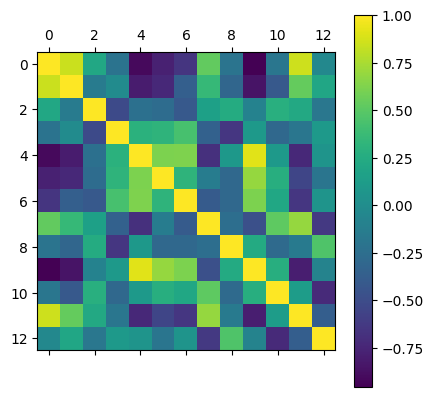

In [260]:
plt.matshow(cor)
plt.colorbar()

In [261]:
cor["tmax"]

Intercept       0.853943
Amplitude       0.538333
FallDay         0.224130
WinterDay      -0.191532
SpringDay      -0.733378
SummerDay      -0.545981
SpringSummer   -0.642841
FallWinter      0.687132
swe            -0.148205
prcp           -0.788311
vp              0.126989
tmax            1.000000
srad           -0.370154
Name: tmax, dtype: float64

In [262]:
csd_w.corr("spearman")["tmax"]

Intercept       0.882143
Amplitude       0.585714
FallDay         0.259160
WinterDay      -0.349779
SpringDay      -0.811502
SummerDay      -0.746196
SpringSummer   -0.635714
FallWinter      0.635714
swe             0.178571
prcp           -0.825000
vp              0.207143
tmax            1.000000
srad           -0.264286
Name: tmax, dtype: float64

In [295]:
csd_tr = csd_w[csd_w.index < 2018]
csd_te = csd_w[csd_w.index >= 2018]

In [296]:
ssn_base = rts.ThreeSine.from_data(csd).to_df()
# Dropped: SpringSummer, SpringDay
names = ["Intercept", "Amplitude", "SummerDay"]

In [297]:
coef_act = csd_tr[names].to_numpy()

In [304]:
pnames = ["prcp"]
def makenp(data):
    return np.concatenate((np.ones((data.shape[0], 1)), data), axis=1)

coef_pr = makenp(csd_tr[pnames].to_numpy())

In [305]:
sol = np.linalg.lstsq(coef_pr, coef_act, rcond=None)[0]
sol  # coefficients

array([[  9.21770694,   9.60358837, 192.54267883],
       [ -1.0448347 ,  -1.09918148,  15.64829604]])

In [306]:
predicted_coefs = pd.DataFrame(makenp(csd_te[pnames].to_numpy()) @ sol, columns=names)
predicted_coefs

,Intercept,Amplitude,SummerDay
0,7.385726,7.676318,219.979915
1,6.167794,6.395035,238.220662
2,7.161005,7.439907,223.345526
3,7.471965,7.767042,218.688335
4,7.414803,7.706907,219.544437


In [307]:
ssn_base[names]

,Intercept,Amplitude,SummerDay
0,6.560523,6.798624,238.0


In [308]:
new_coef = ssn_base.drop(columns=names).merge(predicted_coefs, how="cross").assign(year = range(2018, 2023))
new_coef

,FallDay,WinterDay,SpringDay,SpringSummer,FallWinter,R2,RMSE,Intercept,Amplitude,SummerDay,year
0,316.0,69.0,160.0,2.896524,1.964798,NaN,0.919945,7.385726,7.676318,219.979915,2018
1,316.0,69.0,160.0,2.896524,1.964798,NaN,0.919945,6.167794,6.395035,238.220662,2019
2,316.0,69.0,160.0,2.896524,1.964798,NaN,0.919945,7.161005,7.439907,223.345526,2020
3,316.0,69.0,160.0,2.896524,1.964798,NaN,0.919945,7.471965,7.767042,218.688335,2021
4,316.0,69.0,160.0,2.896524,1.964798,NaN,0.919945,7.414803,7.706907,219.544437,2022


In [309]:
base_ts = rts.ThreeSine.from_coefs(ssn_base).generate_ts().rename(columns={"actemp": "base_actemp"})

In [310]:
new_ts = new_coef.groupby("year").apply(lambda x: rts.ThreeSine.from_coefs(x).generate_ts(), include_groups=False).rename(columns={"actemp": "new_actemp"})
fit_ts = csd_w.groupby("year").apply(lambda x: rts.ThreeSine.from_coefs(x).generate_ts(), include_groups=False).rename(columns={"actemp": "fit_actemp"})

In [311]:
comb = csd[csd["year"] >= 2018].merge(new_ts, on=["year", "day"]).merge(base_ts, on="day").merge(fit_ts, on=["year", "day"])
comb

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,year,day,new_actemp,base_actemp,fit_actemp
0,394220106431500,2018-01-01,0.0,0.000000,268.24414,100.25363,0.598537,NaN,270.31500,2018,1,-0.018338,-0.055597,-1.142088
1,394220106431500,2018-01-02,0.0,0.000000,286.62543,100.25363,-1.149187,NaN,220.52548,2018,2,-0.025279,-0.055999,-1.147297
2,394220106431500,2018-01-03,0.0,0.000000,318.37735,100.25363,3.679039,NaN,256.33646,2018,3,-0.029838,-0.054256,-1.149521
3,394220106431500,2018-01-04,0.0,0.000000,299.08188,100.25363,4.171788,NaN,311.59818,2018,4,-0.032036,-0.050387,-1.148780
4,394220106431500,2018-01-05,0.0,0.000000,270.62653,100.18187,4.081017,NaN,363.79926,2018,5,-0.031890,-0.044414,-1.145093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,394220106431500,2022-12-27,0.0,10.553032,191.49033,NaN,4.154530,NaN,424.24790,2022,361,0.055563,-0.020726,-0.957696
1821,394220106431500,2022-12-28,0.0,8.184340,210.25845,NaN,0.119703,NaN,298.54263,2022,362,0.036194,-0.032142,-0.995771
1822,394220106431500,2022-12-29,0.0,1.973018,218.12827,NaN,-7.772742,NaN,180.07483,2022,363,0.019296,-0.041320,-1.031246
1823,394220106431500,2022-12-30,0.0,7.100912,229.40940,NaN,-4.506784,NaN,182.08226,2022,364,0.004854,-0.048276,-1.064116


             temperature  new_actemp  base_actemp
temperature     1.000000    0.947380     0.925816
new_actemp      0.947380    1.000000     0.971747
base_actemp     0.925816    0.971747     1.000000


<Axes: xlabel='date'>

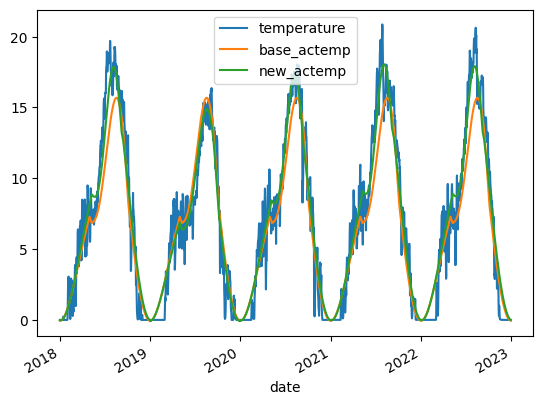

In [313]:
print(comb[["temperature", "new_actemp", "base_actemp"]].corr()**2)
copl = comb#[comb["year"] == 2022]
ax = copl.plot(x="date", y="temperature")
# ax = copl.plot(x="date", y="fit_actemp")
copl.plot(x="date", y="base_actemp", ax=ax)
copl.plot(x="date", y="new_actemp", ax=ax)

Okay, fitting intercept, amplitude, and summer day on precipitation and temperature through day 180 (end of June) works much better.  Boost to correlation is minor, but it catches the peaks much better (if it holds up in cal-val, of course).  June seems to be the sweet spot - performance goes down after that.  (Of the two, precipitation-only works about as well as using both.)

In cal-val, the performance advantage actually grows slightly.

So, next up is to try to fold P/T-driven amplitude, intercept, and summer-day into the general watershed model and see how it does.